In [1]:
!pip install torch-summary
!pip install timm
!pip install opendatasets

     |████████████████████████████████| 431 kB 5.1 MB/s 


In [2]:
!nvidia-smi

Fri Feb 11 07:36:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Import Library

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import math
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np

import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
import torchvision.models as models

from timm.models.layers import trunc_normal_, DropPath
from timm.models.registry import register_model

from torchvision.datasets import ImageFolder
import random
import cv2
from torchvision.utils import make_grid
import os
%matplotlib inline

# 2. Dataset

In [4]:
import opendatasets as od
od.download("https://www.kaggle.com/gpiosenka/100-bird-species")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: doanthong
Your Kaggle Key: ··········


100%|██████████| 1.41G/1.41G [00:05<00:00, 261MB/s]


In [5]:
data_dir = '/content/100-bird-species'  

print(f'Directories: {os.listdir(data_dir)}')
classes = os.listdir(data_dir + "/train")
print(f'Number of classes: {len(classes)}')

Directories: ['test', 'images to test', 'EfficientNetB4-BIRDS-0.98.h5', 'birds.csv', 'class_dict.csv', 'birds latin names.csv', 'train', 'my_csv-2-10-2022-14-44-22.csv', 'valid']
Number of classes: 375


## Transform

In [6]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

train_tfms = transforms.Compose([transforms.RandomCrop(224, padding=15, padding_mode='reflect'),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=mean, std=std, inplace=True)])
valid_tfms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize(mean=mean, std=std, inplace=True)])   

## Data

In [7]:
train_ds = ImageFolder(data_dir+'/train', train_tfms) 
valid_ds = ImageFolder(data_dir+'/valid', valid_tfms) 
test_ds = ImageFolder(data_dir+'/test', valid_tfms) 

## Dataset Info

In [8]:
def dataset_info(dataset):
    print(f'Size of dataset: {len(dataset)}')
    img, label = dataset[0]
    print(f'Sample-01 Image size: {img.shape}, Label: {label}')
    print(f'Number of classes: {len(dataset.classes)}\n\n')

print('Train Dataset\n-----------')
dataset_info(train_ds)
print('Validation Dataset\n-----------')
dataset_info(valid_ds)
print('Test Dataset\n-----------')
dataset_info(test_ds)

Train Dataset
-----------
Size of dataset: 54652
Sample-01 Image size: torch.Size([3, 224, 224]), Label: 0
Number of classes: 375


Validation Dataset
-----------
Size of dataset: 1875
Sample-01 Image size: torch.Size([3, 224, 224]), Label: 0
Number of classes: 375


Test Dataset
-----------
Size of dataset: 1875
Sample-01 Image size: torch.Size([3, 224, 224]), Label: 0
Number of classes: 375




## Dataloader

In [9]:
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [10]:
batch_size = 128

set_seed(0)
train_loader = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=4,  
                      pin_memory=True)  

set_seed(0)
valid_loader = DataLoader(valid_ds, 
                    batch_size * 2,    # for validation we'll not compute gradients, so we'll need half the memory. Therefore we can double the batch size.
                    num_workers=4, 
                    pin_memory=True)

## Show Batch Dataset

In [11]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, mean, std)
        ax.imshow(make_grid(denorm_images[:100], nrow=10).permute(1, 2, 0).clamp(0,1))
        break

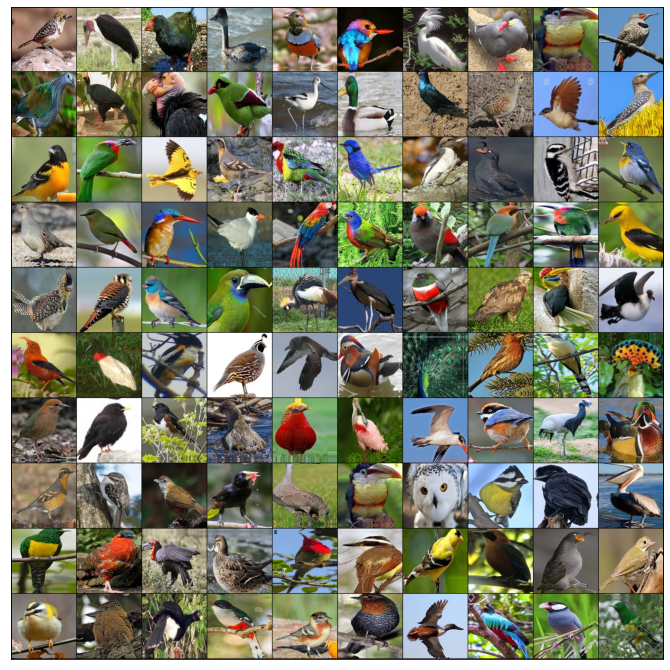

In [12]:
show_batch(train_loader)

# 3. Model

In [13]:
class LayerNorm(nn.Module):
    
    def __init__(self, normalized_shape, eps=1e-6, data_format='channels_last'):
        super().__init__()
        self.weight = nn.parameter.Parameter(torch.ones(normalized_shape))
        self.bias = nn.parameter.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape, )
        
    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(input=x, normalized_shape=self.normalized_shape,
                                weight=self.weight, bias=self.bias, eps=self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x


class Block(nn.Module):
    r""" ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    We use (2) as we find it slightly faster in PyTorch
    
    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
    """
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, dim * 4)
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.parameter.Parameter(layer_scale_init_value * torch.ones((dim)),
                                            requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0 else nn.Identity()
        
    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)
        
        x = input + self.drop_path(x)
        return x
    

class ConvNeXt(nn.Module):
    
    def __init__(self, in_chans=3, num_classes=1000,
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_path_rate=0.,
                 layer_scale_init_value=1e-6, head_init_scale=1.):
        super().__init__()
        
        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)
            
        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rate = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rate[cur + j],
                        layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]
        
        self.norm = nn.LayerNorm(normalized_shape=dims[-1], eps=1e-6)
        self.head = nn.Linear(dims[-1], num_classes)
        
        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)
        
    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)
            
    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1])) # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x
    
model_urls = {
    "convnext_tiny_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth",
    "convnext_small_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_small_1k_224_ema.pth",
    "convnext_base_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth",
    "convnext_large_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_large_1k_224_ema.pth",
    "convnext_base_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_224.pth",
    "convnext_large_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth",
    "convnext_xlarge_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_xlarge_22k_224.pth",
}


@register_model
def convnext_tiny(pretrained=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], **kwargs)
    if pretrained:
        url = model_urls['convnext_tiny_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu", check_hash=True)
        model.load_state_dict(checkpoint["model"])
    return model


@register_model
def convnext_small(pretrained=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[96, 192, 384, 768], **kwargs)
    if pretrained:
        url = model_urls['convnext_small_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu")
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def convnext_base(pretrained=False, in_22k=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[128, 256, 512, 1024], **kwargs)
    if pretrained:
        url = model_urls['convnext_base_22k'] if in_22k else model_urls['convnext_base_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu")
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def convnext_large(pretrained=False, in_22k=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[192, 384, 768, 1536], **kwargs)
    if pretrained:
        url = model_urls['convnext_large_22k'] if in_22k else model_urls['convnext_large_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu")
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def convnext_xlarge(pretrained=False, in_22k=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[256, 512, 1024, 2048], **kwargs)
    if pretrained:
        assert in_22k, "only ImageNet-22K pre-trained ConvNeXt-XL is available; please set in_22k=True"
        url = model_urls['convnext_xlarge_22k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu")
        model.load_state_dict(checkpoint["model"])
    return model

## Test model

In [14]:
def test(device='cpu'):
    model = convnext_tiny(pretrained=True)
    # print(model)
    from torchsummary import summary
    summary(model, input_size=(3, 224, 224), device=device)
    x = torch.randn(1, 3, 224, 224)
    y = model(x).to(device)
    print(y.shape)

test(device='cpu')

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_1k_224_ema.pth


  0%|          | 0.00/109M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Param #
├─ModuleList: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  4,704
|    |    └─LayerNorm: 3-2               192
|    └─Sequential: 2-2                   --
|    |    └─LayerNorm: 3-3               192
|    |    └─Conv2d: 3-4                  73,920
|    └─Sequential: 2-3                   --
|    |    └─LayerNorm: 3-5               384
|    |    └─Conv2d: 3-6                  295,296
|    └─Sequential: 2-4                   --
|    |    └─LayerNorm: 3-7               768
|    |    └─Conv2d: 3-8                  1,180,416
├─ModuleList: 1-2                        --
|    └─Sequential: 2-5                   --
|    |    └─Block: 3-9                   79,296
|    |    └─Block: 3-10                  79,296
|    |    └─Block: 3-11                  79,296
|    └─Sequential: 2-6                   --
|    |    └─Block: 3-12                  306,048
|    |    └─Block: 3-13        

# 4. Trainer

In [15]:
def check_accuracy(loader, model, device):
    num_correct = 0
    num_sample = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            
            scores = model(x)
            _, prediction = scores.max(1)
            num_correct += (prediction == y).sum()
            num_sample += prediction.size(0)
            
    model.train()
    acc = round(float(num_correct) / float(num_sample), 4)
    
    return acc

In [16]:
def train_epoch(dataloader, model, criterion, optimizer, device='cpu'):
    model = model.to(device)
    model.train()
    loss_epoch = []

    for batch_idx, (data, target) in enumerate(dataloader):
        data = data.to(device)
        target = target.to(device)

        # forward
        score = model(data)
        loss = criterion(score, target)
        loss_epoch.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # optimizer
        optimizer.step()
        
    train_loss = sum(loss_epoch) / len(loss_epoch)
    train_acc = check_accuracy(dataloader, model, device)

    return train_loss, train_acc

def valid_epoch(validloader, model, criterion, device='cpu'):
    model = model.to(device)
    model.eval()
    loss_epoch = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(validloader):
            data = data.to(device)
            target = target.to(device)

            score = model(data)
            loss = criterion(score, target)
            loss_epoch.append(loss.item())

        valid_loss = sum(loss_epoch) / len(loss_epoch)
        valid_acc = check_accuracy(validloader, model, device)

    return valid_loss, valid_acc

# 5. Run Training

# Initialize

In [17]:
def save_checkpoint(checkpoint, filename='checkpoint_ConvNeXt.pth'):
    print("=> saving checkpoint")
    torch.save(checkpoint, filename)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device = {}".format(device))

Using device = cuda


## Hyperparameter

In [19]:
in_channel = 3
num_classes = 375

In [20]:
model = convnext_tiny(pretrained=True)
model.head = nn.Linear(in_features=768, out_features=num_classes, bias=True)

## Loss, optimizer and Scheduler

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.92, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=6,
                                                 eps=1e-8, verbose=True, cooldown=0, min_lr=0)

## Training

In [24]:
train_loss_his, train_acc_his = [], []
valid_loss_his, valid_acc_his = [], []

best_valid_accuracy = 0.

In [22]:
learning_rate = 0.1
epochs = 30

In [25]:
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(train_loader, model, criterion=criterion,
                                        optimizer=optimizer, device=device)
    valid_loss, valid_acc = valid_epoch(valid_loader, model, criterion=criterion, device=device)

    print(f"Epoch {(epoch + 1):>2d}: - train_loss: {train_loss:>7f}, train accuracy: {(train_acc*100):>0.1f}%")
    print(f"Epoch {(epoch + 1):>2d}: - valid_loss: {valid_loss:>7f}, valid accuracy: {(valid_acc*100):>0.1f}%")
    
    if epoch == 0:
        best_valid_accuracy = valid_acc
        checkpoint = {'state_dict': model.state_dict(),
                      'optimizer': optimizer.state_dict()}
        save_checkpoint(checkpoint)
        
    if valid_acc > best_valid_accuracy:
        checkpoint = {'state_dict': model.state_dict(),
                      'optimizer': optimizer.state_dict()}
        save_checkpoint(checkpoint)
        best_valid_accuracy = valid_acc
        
    print()

    scheduler.step(valid_loss)

    train_loss_his.append(train_loss)
    train_acc_his.append(train_acc)
    valid_loss_his.append(valid_loss)
    valid_acc_his.append(valid_acc)

print(best_valid_accuracy)
print(train_loss_his)
print(valid_loss_his)
print(train_acc_his)
print(valid_acc_his)

Epoch  1: - train_loss: 1.484832, train accuracy: 92.8%
Epoch  1: - valid_loss: 0.185195, valid accuracy: 94.8%
=> saving checkpoint

Epoch  2: - train_loss: 0.251108, train accuracy: 96.2%
Epoch  2: - valid_loss: 0.122681, valid accuracy: 96.7%
=> saving checkpoint

Epoch  3: - train_loss: 0.141074, train accuracy: 97.5%
Epoch  3: - valid_loss: 0.119520, valid accuracy: 96.6%

Epoch  4: - train_loss: 0.083574, train accuracy: 98.8%
Epoch  4: - valid_loss: 0.091845, valid accuracy: 97.8%
=> saving checkpoint

Epoch  5: - train_loss: 0.055926, train accuracy: 99.1%
Epoch  5: - valid_loss: 0.087346, valid accuracy: 97.9%
=> saving checkpoint

Epoch  6: - train_loss: 0.042320, train accuracy: 99.0%
Epoch  6: - valid_loss: 0.101685, valid accuracy: 97.5%

Epoch  7: - train_loss: 0.041557, train accuracy: 99.1%
Epoch  7: - valid_loss: 0.101958, valid accuracy: 97.7%

Epoch  8: - train_loss: 0.041823, train accuracy: 99.1%
Epoch  8: - valid_loss: 0.141348, valid accuracy: 97.2%

Epoch  9: - 

In [26]:
print("Best valid accuracy: ",best_valid_accuracy)

Best valid accuracy:  0.9888


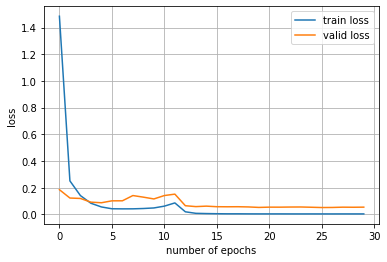

In [27]:
plt.plot(train_loss_his, label='train loss')
plt.plot(valid_loss_his, label='valid loss')
plt.grid('on')
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

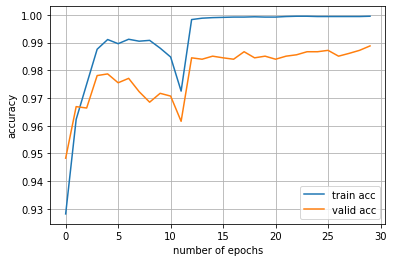

In [28]:
plt.plot(train_acc_his, label='train acc')
plt.plot(valid_acc_his, label='valid acc')
plt.grid('on')
plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()